In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import kernels, GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances

from umda.data import load_data, load_pipeline
from umda.training import get_bootstrap_samples, compose_model

In [2]:
tmc1_df = load_data(exclude_hydrogen=True)[-1]
tmc1_df["Molecule"] = tmc1_df["Molecule"].replace(np.nan, "")

In [3]:
embedder = load_pipeline()

/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator IncrementalPCA from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 0.24

In [4]:
X = np.asarray([embedder.vectorize(smi) for smi in tmc1_df["SMILES"]])
Y = np.log10(tmc1_df["Column density (cm^-2)"]).values

In [5]:
boot_X, boot_Y = get_bootstrap_samples((X, Y), seed=1295016, n_samples=400, replace=True)

In [6]:
# kernel =  kernels.RationalQuadratic(length_scale_bounds=(1e-1, 1e4), alpha_bounds=(1e-2, 1e1)) * kernels.ConstantKernel(constant_value_bounds=(1e-2, 1e2)) + kernels.RBF(length_scale_bounds=(1e-1, 50.)) * 1e-2
# kernel = (kernels.RationalQuadratic(alpha=100., length_scale=0.5) * 1. + kernels.Matern() * 1.) + kernels.WhiteKernel()
kernel = kernels.RationalQuadratic() + kernels.DotProduct() + kernels.WhiteKernel()

In [7]:
gp = GaussianProcessRegressor(kernel, random_state=215016, n_restarts_optimizer=0, alpha=1e-2, normalize_y=True)

model = compose_model(gp, True)
prior_y = model["regressor"].sample_y(X, random_state=21416)

In [8]:
train_X, test_X, train_y, test_y = train_test_split(boot_X, boot_Y, train_size=0.2, random_state=161962)
result = model.fit(train_X, train_y)

In [9]:
pred_Y, pred_std = model.predict(X, return_std=True)

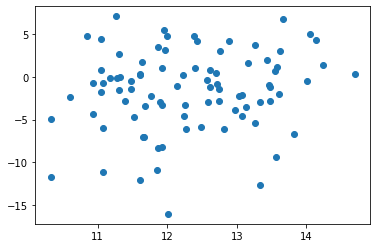

In [10]:
plt.scatter(Y, prior_y)

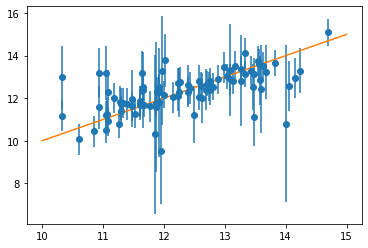

In [11]:
plt.errorbar(Y, pred_Y, fmt="o", yerr=pred_std)
plt.plot(np.arange(10, 16), np.arange(10, 16),)
# plt.ylim([9.5, 15.5])

In [12]:
print(result["regressor"].kernel_)

print(result["regressor"])

RationalQuadratic(alpha=0.101, length_scale=1.02) + DotProduct(sigma_0=0.000486) + WhiteKernel(noise_level=0.225)
GaussianProcessRegressor(alpha=0.01,
                         kernel=RationalQuadratic(alpha=1, length_scale=1) + DotProduct(sigma_0=1) + WhiteKernel(noise_level=1),
                         normalize_y=True, random_state=215016)


In [124]:
result["regressor"].log_marginal_likelihood_value_

-138.5320218232772

In [195]:
chosen = tmc1_df.loc[(tmc1_df["Molecule"].str.contains("Methyl")) & ~(tmc1_df["Molecule"].str.contains("radical"))]
chosen.sort_values(["Column density (cm^-2)"], ascending=False, inplace=True)

/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [867]:
chosen_vecs = np.asarray([embedder.vectorize(smi) for smi in chosen["SMILES"]])

In [873]:
model["regressor"]

GaussianProcessRegressor(alpha=0.001,
                         kernel=RationalQuadratic(alpha=200, length_scale=0.5) * 1**2 + Matern(length_scale=1, nu=1.5) * 1**2 + WhiteKernel(noise_level=1),
                         random_state=215016)

In [220]:
from sklearn.svm import SVR

In [242]:
model = SVR(epsilon=0.01, C=300., kernel="rbf", gamma=0.05, shrinking=True)

In [243]:
result = model.fit(train_X, train_y)

In [244]:
result.score(X, Y)

0.5514133420059352

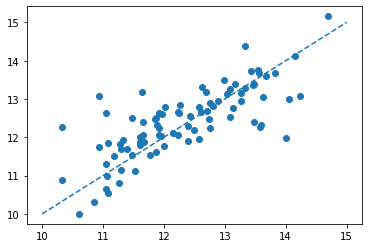

In [245]:
plt.scatter(Y, result.predict(X))
plt.plot(np.arange(10, 16), np.arange(10, 16), ls="--")

In [225]:
from sklearn.ensemble import GradientBoostingRegressor

In [226]:
gbr = GradientBoostingRegressor()

In [230]:
result = gbr.fit(boot_X, boot_Y)

In [231]:
result.score(X, Y)

0.9462891936397603

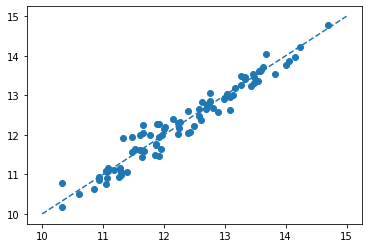

In [232]:
plt.scatter(Y, result.predict(X))
plt.plot(np.arange(10, 16), np.arange(10, 16), ls="--")